In [1]:
from math import tan, sin, cos, sqrt, atan2
from sympy import Symbol, symbols, Matrix, sin, cos
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.kalman import MerweScaledSigmaPoints
from filterpy.kalman import UnscentedKalmanFilter
from filterpy.kalman import JulierSigmaPoints
from filterpy.stats import plot_covariance_ellipse
from filterpy.common import Saver
from filterpy.common import Q_discrete_white_noise
from filterpy.kalman import KalmanFilter
from sympy import init_printing
import pandas as pd
from scipy.stats import norm
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import math
import numpy as np
from numpy.random import randn
pd.set_option('display.max_columns', 50)


init_printing(use_latex=True)


## Situtation Covered Breif Explanation
1. Velocity sensor is there,measures speed in heading direction
2. YawRate sensor
3. Position information from a GPS sensor (x,y)
4. Thus the measurement state is four [x,y,velocity,yawrate].
5. The state of the kalman is five [x,y,yaw,velocity,yawrate].
6. The motion model while travelling straight and while turning is different 
7. The gps measurements are not available in all the cycles and the measurements will be will have x and y when we are having gps. Here when we are not having gps I am using the prediction as the measurement.


In [2]:
#we need the robot motion model for the predict method
def move(x,yawrateCurrent):
  
    if np.abs(yawrateCurrent)<0.0001: # Driving straight
        x[0] = x[0] + x[3]*dt * np.cos(x[2])
        x[1] = x[1] + x[3]*dt * np.sin(x[2])
        x[2] = x[2]
        x[3] = x[3]
        x[4] = 0.0000001 # avoid numerical issues in Jacobians
      
    else: # otherwise
        x[0] = x[0] + (x[3]/x[4]) * (np.sin(x[4]*dt+x[2]) - np.sin(x[2]))
        x[1] = x[1] + (x[3]/x[4]) * (-np.cos(x[4]*dt+x[2])+ np.cos(x[2]))
        x[2] = (x[2] + x[4]*dt + np.pi) % (2.0*np.pi) - np.pi
        x[3] = x[3]
        x[4] = x[4]
        
    return x

In [3]:

def normalize_angle(x):
    x = x % (2 * np.pi)    # force in range [0, 2 pi)
    if x > np.pi:          # move to [-pi, pi)
        x -= 2 * np.pi
    return x

In [4]:
# this is used when calculating the sigma points
def residual_x(a, b):
    y = a - b
    # we have the angle at the second position so we need to normalize it to [-pi to pi]
    y[2] = normalize_angle(y[2])
    return y


In [5]:
def Hx(x):
    hx = np.array([float(x[0]), float(x[1]), float(x[3]), float(x[4])])
    return hx


# we need to take the mean of the angle which is not easy
# this is used when calculating the sigma points
def state_mean(sigmas, Wm):
    z = np.zeros(5)

    sum_sin = np.sum(np.dot(np.sin(sigmas[:, 2]), Wm))
    sum_cos = np.sum(np.dot(np.cos(sigmas[:, 2]), Wm))
    x[0] = np.sum(np.dot(sigmas[:, 0], Wm))
    x[1] = np.sum(np.dot(sigmas[:, 1], Wm))
    x[2] = atan2(sum_sin, sum_cos)
    x[3] = np.sum(np.dot(sigmas[:, 3], Wm))
    x[4] = np.sum(np.dot(sigmas[:, 4], Wm))

    return x

In [6]:
numstates=5 # States
dt = 1.0/50.0 # Sample Rate of the Measurements is 50Hz
dtGPS=1.0/10.0 # Sample Rate of GPS is 10Hz

In [7]:
P = np.diag([1000.0, 1000.0, 1000.0, 1000.0, 1000.0])
print(P, P.shape)

[[1000.    0.    0.    0.    0.]
 [   0. 1000.    0.    0.    0.]
 [   0.    0. 1000.    0.    0.]
 [   0.    0.    0. 1000.    0.]
 [   0.    0.    0.    0. 1000.]] (5, 5)


In [8]:
(P + P.transpose())/2

array([[1000.,    0.,    0.,    0.,    0.],
       [   0., 1000.,    0.,    0.,    0.],
       [   0.,    0., 1000.,    0.,    0.],
       [   0.,    0.,    0., 1000.,    0.],
       [   0.,    0.,    0.,    0., 1000.]])

In [9]:
sGPS     = 0.5*8.8*dt**2  # assume 8.8m/s2 as maximum acceleration, forcing the vehicle
sCourse  = 0.1*dt # assume 0.1rad/s as maximum turn rate for the vehicle
sVelocity= 8.8*dt # assume 8.8m/s2 as maximum acceleration, forcing the vehicle
sYaw     = 1.0*dt # assume 1.0rad/s2 as the maximum turn rate acceleration for the vehicle

Q = np.diag([sGPS**2, sGPS**2, sCourse**2, sVelocity**2, sYaw**2])
print(Q, Q.shape)

[[3.0976e-06 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
 [0.0000e+00 3.0976e-06 0.0000e+00 0.0000e+00 0.0000e+00]
 [0.0000e+00 0.0000e+00 4.0000e-06 0.0000e+00 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 3.0976e-02 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 4.0000e-04]] (5, 5)


In [10]:
datafile = '../Data/2014-03-26-000-Data.csv'
df = pd.read_csv(datafile)

In [11]:
altitude = df['altitude'].values
latitude = df['latitude'].values
longitude = df['longitude'].values
course  = df['course'].values
speed = df['speed'].values
yawrate  = df['yawrate'].values
# A course of 0° means the Car is traveling north bound
# and 90° means it is traveling east bound.
# In the Calculation following, East is Zero and North is 90°
# We need an offset.
course =(-course+90.0)

In [12]:
varGPS = 6.0 # Standard Deviation of GPS Measurement
varspeed = 1.0 # Variance of the speed measurement
varyaw = 0.1 # Variance of the yawrate measurement
R = np.matrix([[varGPS**2, 0.0, 0.0, 0.0],
               [0.0, varGPS**2, 0.0, 0.0],
               [0.0, 0.0, varspeed**2, 0.0],
               [0.0, 0.0, 0.0, varyaw**2]])

print(R, R.shape)

[[3.6e+01 0.0e+00 0.0e+00 0.0e+00]
 [0.0e+00 3.6e+01 0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00 1.0e+00 0.0e+00]
 [0.0e+00 0.0e+00 0.0e+00 1.0e-02]] (4, 4)


In [13]:
RadiusEarth = 6378388.0 # m
#this line tells us about the meters per degree
arc= 2.0*np.pi*(RadiusEarth+altitude)/360.0 # m/°

dx = arc * np.cos(latitude*np.pi/180.0) * np.hstack((0.0, np.diff(longitude))) # in m
dy = arc * np.hstack((0.0, np.diff(latitude))) # in m

mx = np.cumsum(dx)
my = np.cumsum(dy)

ds = np.sqrt(dx**2+dy**2)

GPS=(ds!=0.0).astype('bool') # GPS Trigger for Kalman Filter

In [14]:
measurements = np.vstack((mx, my, speed/3.6, yawrate/180.0*np.pi))
# Lenth of the measurement
m = measurements.shape[1]
print(measurements.shape)

(4, 10800)


[ 0.          0.         -4.08756111  0.67322222 -0.32660346] (5,)


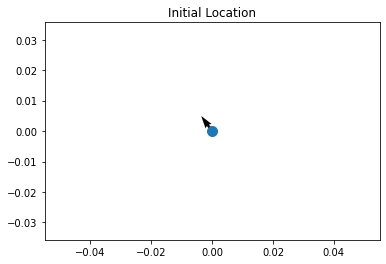

In [15]:
#In other words, the value in km/h divide by 3.6 to get a value in m/s.
x= np.array([mx[0], my[0], course[0]/180.0*np.pi, speed[0]/3.6+0.001, yawrate[0]/180.0*np.pi]).T
print(x, x.shape)
x_initial = x

U=float(np.cos(x[2])*x[3])
V=float(np.sin(x[2])*x[3])

plt.quiver(x[0], x[1], U, V)
plt.scatter(float(x[0]), float(x[1]), s=100)
plt.title('Initial Location')
plt.axis('equal')

In [16]:
points = MerweScaledSigmaPoints(n=5, alpha=.00001, beta=2, kappa=0,
                                    subtract=residual_x)
ukf = UKF(dim_x=5,dim_z=4,fx=move,hx=Hx,dt=dt,points=points,x_mean_fn=state_mean,
         residual_x=residual_x)

In [17]:
ukf.x = x_initial
ukf.P = P
ukf.R = R

In [18]:
points = JulierSigmaPoints(n=5, kappa=-2)
noOfMeasurements = measurements.shape[1]

ukf = UKF(dim_x=5, dim_z=4, fx=move, hx=Hx, dt=dt, points=points, x_mean_fn=state_mean,
          residual_x=residual_x)

s = Saver(ukf)
ukf.x = x_initial
ukf.P = P
ukf.R = R


for filterstep in range(noOfMeasurements):
    #print(filterstep)

    yawRateCurrent = yawrate[filterstep]

    # while taking measurements there we will get GPS only in some cycles
    # as of now I am just using the predicted states as measurements when there is not gps
    # the predict is using move behind the scenes and we should pass all the arguments move requries
    # x will be passed automatically  and the remaining we need to supply.
    ukf.P = (ukf.P + ukf.P.transpose())/2
    ukf.predict(yawRateCurrent)

    if GPS[filterstep]:
        z = measurements[:, filterstep].reshape(-1,)
    else:
        z = measurements[:, filterstep].reshape(-1,)
        z[0] = ukf.x[0]
        z[1] = ukf.x[1]

    ukf.update(z)
    s.save()

print("EXITING LOOP")

EXITING LOOP


In [19]:
outStates = np.array(s.x)

In [20]:
outStates.shape

In [21]:
outStates = np.array(s.x)
def plotx():
    fig = plt.figure(figsize=(16,16))

    plt.subplot(411)
    plt.step(range(len(measurements[0])),outStates[:,0]-mx[0], label='$x$')
    plt.step(range(len(measurements[0])),outStates[:,1]-my[0], label='$y$')

    plt.title('Extended Kalman Filter State Estimates (State Vector $x$)')
    plt.legend(loc='best',prop={'size':22})
    plt.ylabel('Position (relative to start) [m]')

    plt.subplot(412)
    plt.step(range(len(measurements[0])),outStates[:,2], label='$\psi$')
    plt.step(range(len(measurements[0])),(course/180.0*np.pi+np.pi)%(2.0*np.pi) - np.pi, label='$\psi$ (from GPS as reference)')
    plt.ylabel('Course')
    plt.legend(loc='best',prop={'size':16})

    plt.subplot(413)
    plt.step(range(len(measurements[0])),outStates[:,3], label='$v$')
    plt.step(range(len(measurements[0])),speed/3.6, label='$v$ (from GPS as reference)')
    plt.ylabel('Velocity')
    plt.ylim([0, 30])
    plt.legend(loc='best',prop={'size':16})

    plt.subplot(414)
    plt.step(range(len(measurements[0])),outStates[:,4], label='$\dot \psi$')
    plt.step(range(len(measurements[0])),yawrate/180.0*np.pi, label='$\dot \psi$ (from IMU as reference)')
    plt.ylabel('Yaw Rate')
    plt.ylim([-0.6, 0.6])
    plt.legend(loc='best',prop={'size':16})
    plt.xlabel('Filter Step')

    plt.savefig('Extended-Kalman-Filter-CTRV-State-Estimates.png', dpi=72, transparent=True, bbox_inches='tight')

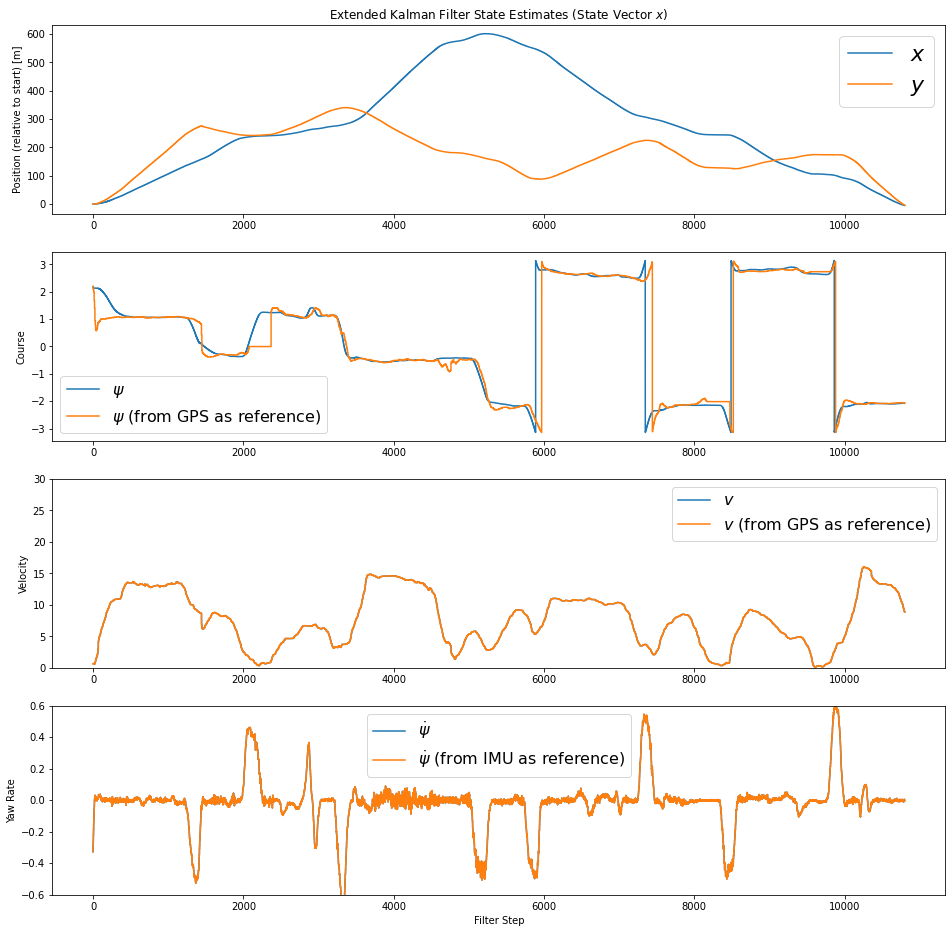

In [22]:
plotx()

In [23]:
covMatrix = np.array(s.P)
def plotP(covMatrix):
    fig = plt.figure(figsize=(16,9))
    plt.semilogy(range(m),covMatrix[:,0,0], label='$x$')
    plt.step(range(m),covMatrix[:,1,1], label='$y$')
    plt.step(range(m),covMatrix[:,2,2], label='$\psi$')
    plt.step(range(m),covMatrix[:,3,3], label='$v$')
    plt.step(range(m),covMatrix[:,4,4], label='$\dot \psi$')

    plt.xlabel('Filter Step')
    plt.ylabel('')
    plt.title('Uncertainty (Elements from Matrix $P$)')
    plt.legend(loc='best',prop={'size':22})

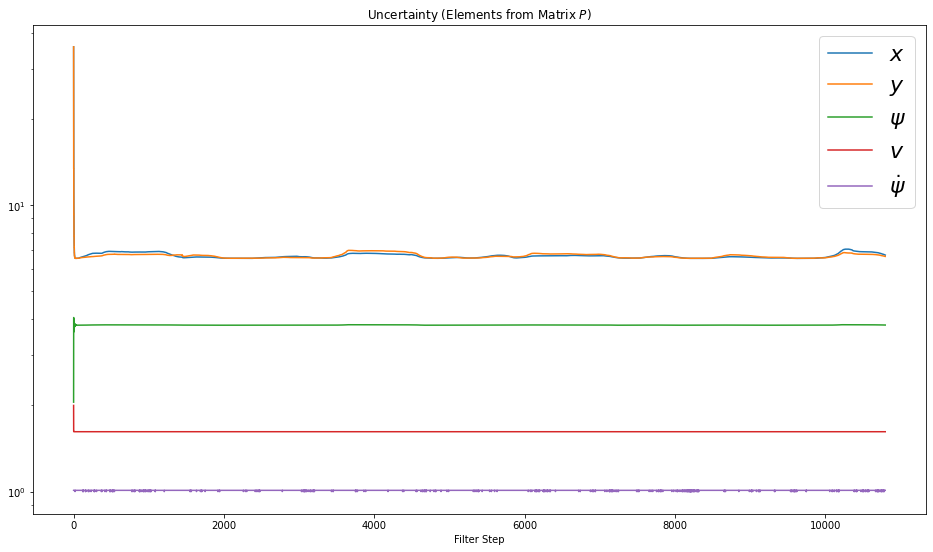

In [24]:
plotP(covMatrix)

<AxesSubplot:>

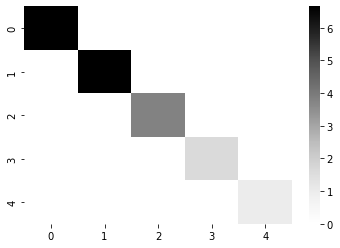

In [25]:
summed = np.sum(covMatrix,axis=0)/covMatrix.shape[0]
sns.heatmap(summed,cmap='Greys')

In [26]:
STATES = np.array(s.x)

In [27]:
x0 = STATES[:,0]
x1 = STATES[:,1]
x2 = STATES[:,2]
x3 = STATES[:,3]
x4 = STATES[:,4]

In [28]:
def plotxy():

    fig = plt.figure(figsize=(16,9))

    # EKF State
    plt.quiver(x0,x1,np.cos(x2), np.sin(x2), color='#94C600', units='xy', width=0.05, scale=0.5)
    plt.plot(x0,x1, label='EKF Position', c='k', lw=5)

    # Measurements
    plt.scatter(mx[::5],my[::5], s=50, label='GPS Measurements', marker='+')
    #cbar=plt.colorbar(ticks=np.arange(20))
    #cbar.ax.set_ylabel(u'EPE', rotation=270)
    #cbar.ax.set_xlabel(u'm')

    # Start/Goal
    plt.scatter(x0[0],x1[0], s=60, label='Start', c='g')
    plt.scatter(x0[-1],x1[-1], s=60, label='Goal', c='r')

    plt.xlabel('X [m]')
    plt.ylabel('Y [m]')
    plt.title('Position')
    plt.legend(loc='best')
    plt.axis('equal')
    #plt.tight_layout()

    #plt.savefig('Extended-Kalman-Filter-CTRV-Position.png', dpi=72, transparent=True, bbox_inches='tight')

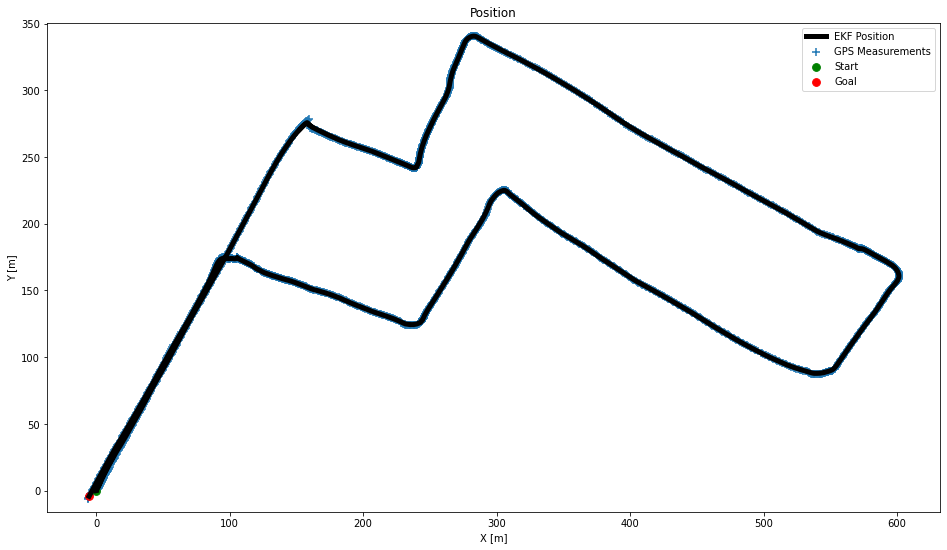

In [29]:
plotxy()

In [30]:
def plotxydetails():
    fig = plt.figure(figsize=(12,9))

    plt.subplot(221)
    # EKF State
    #plt.quiver(x0,x1,np.cos(x2), np.sin(x2), color='#94C600', units='xy', width=0.05, scale=0.5)
    plt.plot(x0,x1, label='EKF Position', c='g', lw=5)

    # Measurements
    plt.scatter(mx[::5],my[::5], s=50, label='GPS Measurements', alpha=0.5, marker='+')
    #cbar=plt.colorbar(ticks=np.arange(20))
    #cbar.ax.set_ylabel(u'EPE', rotation=270)
    #cbar.ax.set_xlabel(u'm')

    plt.xlabel('X [m]')
    plt.xlim(70, 130)
    plt.ylabel('Y [m]')
    plt.ylim(140, 200)
    plt.title('Position')
    plt.legend(loc='best')


    plt.subplot(222)

    # EKF State
    #plt.quiver(x0,x1,np.cos(x2), np.sin(x2), color='#94C600', units='xy', width=0.05, scale=0.5)
    plt.plot(x0,x1, label='EKF Position', c='g', lw=5)

    # Measurements
    plt.scatter(mx[::5],my[::5], s=50, label='GPS Measurements', alpha=0.5, marker='+')
    #cbar=plt.colorbar(ticks=np.arange(20))
    #cbar.ax.set_ylabel(u'EPE', rotation=270)
    #cbar.ax.set_xlabel(u'm')

    plt.xlabel('X [m]')
    plt.xlim(160, 260)
    plt.ylabel('Y [m]')
    plt.ylim(110, 160)
    plt.title('Position')
    plt.legend(loc='best')

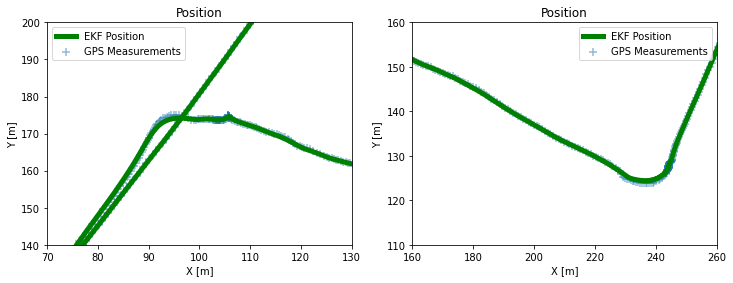

In [31]:
plotxydetails()